# Residence Index

This residence index tool will take a compressed or uncompressed detection file and caculate the residency 
index for each station/receiver in the detections. A CSV file will be written to the data directory
for future use. A Pandas DataFrame is returned from the function, which can be used to plot the information. 
The information passed to the function is what is used to calculate the residence index, __make sure you are only
passing the data you want taken into consideration for the residence index (i.e. species, stations, tags, etc.)__.




### Variables

#### residence_index(detections, calculation_method, table)


__detections:__ The CSV file in the data directory that is either compressed or raw. If the file is not compressed 
please allow the program time to compress the file and add the rows to the database. A compressed file will be created
in the data directory. Use the compressed file for any future runs of the residence index function.

<hr/>

__calculation_method:__ The method used to calculate the residence index. 

Methods are:
- kessel 
- timedelta
- aggregate_with_overlap
- aggregate_no_overlap.

The calculation methods are listed and described below before they are called. The function will default to the
Kessel method when nothing is passed.

<hr/>

__table:__ The database table to use to determine the station/receiver location(lat, long). If no table is passed the 
function will try to determine the table name from detection file name.







<hr/>

__Kessel et al. Paper - https://www.researchgate.net/publication/279269147 __

In [1]:
from otntoolbox import kessel_ri as ri
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm

%matplotlib inline
matplotlib.style.use('ggplot')

# Declare the uncompressed detections file you want to plot
detfile = ""

In [2]:
#############################################
#
# Plotting Function
# -----------------
#
# Passing the returned pandas DataFrame from the residence_index() function to
# this function will plot out the residence index
#
# Size, boundaries, and colors can be modified to tweek the plot.
#
#############################################

def plot_ri(ri):
    # Friendly message
    print 'Creating plot, please wait...',
    
    # Modify the plot dimensions
    fig = plt.figure(figsize=(12,12))
    
    # Create the map
    map = Basemap(projection='merc',
                  resolution='f',
                  # Modify the values /to adjust the boundries of the plot
                  llcrnrlat=ri['latitude'].min()-0.01, urcrnrlat=ri['latitude'].max()+0.01,
                  llcrnrlon=ri['longitude'].min()-0.01, urcrnrlon=ri['longitude'].max()+0.01)
    
    # Modify the color of the water
    map.drawmapboundary(fill_color='#718ea4')
    
    #Modify the color of land
    map.fillcontinents(color='#2a7e43')
    
    # Modify the residence index coloring
    # http://scipy.github.io/old-wiki/pages/Cookbook/Matplotlib/Show_colormaps
    index_coloring = cm.Oranges

    indices = [ri['residency_index']]

    x,y = map(ri['longitude'].values, ri['latitude'].values)
    ri_map = map.scatter(x, y, s=ri['residency_index']*300, c=indices, cmap=index_coloring)
    ri_map.set_clim(0,1)
    cbar = plt.colorbar()

    print 'OK!'
    plt.show()


## Kessel Residence Index Calculation
The Kessel method converts both the startdate and enddate columns into a date with no hours, minutes,
or seconds. Next it creates a list of the unique days where a detection was seen. The size of the
list is returned as the total number of days as an integer. This calculation is used to determine the 
total number of distinct days (T) and the total number of distinct days per station (S).

<hr/>
# $RI = \frac{S}{T}$

RI = Residence Index

S = Distinct number of days detected at the station

T = Distinct number of days detected anywhere on the array
<hr/>


*** NOTE ****
Possible rounding error may occur as a detection on 2016-01-01 23:59:59 and a detection on
2016-01-02 00:00:01 would be counted as two days when it is really 2-3 seconds.

Creating the residency index using the kessel method.
Please be patient, I am currently working... OK!
Creating plot, please wait...

/Users/alexnunes/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/alexnunes/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/alexnunes/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


 OK!


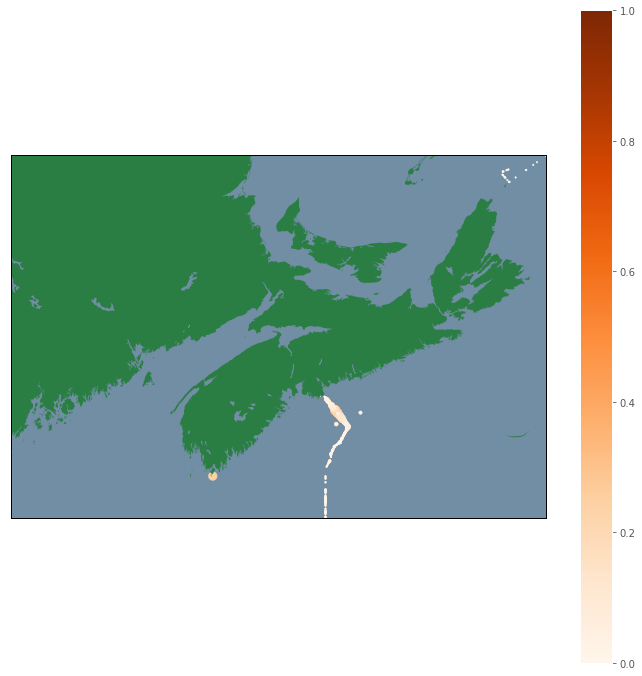

In [3]:
# From Raw Detection File
kessel_ri = ri.residency_index(detfile, calculation_method='kessel')

plot_ri(kessel_ri)

## Timedelta Residence Index Calculation
The Timedelta calculation method determines the first startdate of all detections and the last
enddate of all detections. The time difference is then taken as the values to be used in 
calculating the residence index. The timedelta for each station is divided by the timedelta 
of the array to determine the residence index.


<hr/>
# $RI = \frac{\Delta S}{\Delta T} $

RI = Residence Index

$\Delta S$ = Last detection time at a station - First detection time at the station

$\Delta T$ = Last detection time on an array - First detection time on the array

In [ ]:
# From Raw Detection File
timedelta_ri = ri.residency_index(detfile, calculation_method='timedelta')

plot_ri(timedelta_ri)

## Aggregate With Overlap Residence Index Calculation
The Aggregate With Overlap calculation method takes the length of time of each detection and sums
them together. A total is returned. The sum for each station is then divided by the sum of the
array to determine the residence index.

<hr/>
# $RI = \frac{AwOS}{AwOT} $

RI = Residence Index

AwOS = Sum of length of time of each detection at the station

AwOT = Sum of length of time of each detection on the array

In [ ]:
# From Raw Detection File
with_overlap_ri = ri.residency_index(detfile, calculation_method='aggregate_with_overlap')

plot_ri(with_overlap_ri)

## Aggregate No Overlap Residence Index Calculation
The Aggregate No Overlap calculation method takes the length of time of each detection and sums
them together. However, any overlap in time between one or more detections is excluded from the sum.


For example, if the first detection is from __2016-01-01 01:02:43__ to __2016-01-01 01:10:12__ and the second
detection is from __2016-01-01 01:09:01__ to __2016-01-01 01:12:43__, then the sume of those two detections 
would be 10 minutes.


A total is returned once all detections of been added without overlap. The sum for each station is then 
divided by the sum of the array to determine the residence index.


<hr/>
# $RI = \frac{AnOS}{AnOT} $

RI = Residence Index

AnOS = Sum of length of time of each detection at the station, excluding any overlap

AnOT = Sum of length of time of each detection on the array, excluding any overlap

In [ ]:
# From Raw Detection File
no_overlap_ri = ri.residency_index(detfile, calculation_method='aggregate_no_overlap')

plot_ri(no_overlap_ri)